# QUIC 

QUIC is a network protocol developed by Google. As compared to defacto network protocol OKHTTP/h2, QUIC helps improve network latencies for tail end of users. This workbook evaluate the impact of using QUIC protocol on Uber's business metric. On 10/25/2018, QUIC network protocol was enabled on :

1. 50% of users using android phones in San Paulo, London, Los Angeles, Cairo and New Delhi. For this segment, the data is collected using a sampling rate of 5%. 
2. 50% of users using Iphone in the above cities. For this segment, the data is collected using a sampling rate of 20%
3. 20% of users using android phone in the rest of the cities. For this segment, the data is collected using a sampling rate of 5%. 

There are three configuration options that can affect observed network latencies. 
1. Library: There are two libraries: OKHTTP and CRONET. 
2. Protocol: OKHTTP implements two different protocols: http/1.1 and h2. CRONET also implements two different protocols: h2 and QUIC. Generally in terms of performance http/1.1 is slowest and is rarely used. In case of CRONET, h2 is used as a fallback, that is if quic protocol doesn't work then the request will fall back to h2. Hence, one expect that CRONET/h2 to perform worse than OKHTTP/h2. 
3. Hosts: The request can be fullfilled either by Uber's on premise data center or by google cloud frontend (also referred as CFE in logs). QUIC can only work on CFE. 

Since QUIC is only available via CFE, this analysis only focuses on sessions where all the requests where handled CFE. In order to speed up analysis, we created four tables:

1. **dsp.quic_sessions:** This table includes session level network information such as hosts, protocols and libraries that were used to serve the requests in a session. You can find the actual SQL script used to generate the session in this notebook.  
2. **dsp.quic_session_info:** This tables includes session level user activity information such as how many trips were completed (n_completed), sequence of events (transitions), etc. 
3. **dsp.quic:** This table is inner join of the above two tables. The join is based on session_id and rider_id. Ideally the join should be only based on session_id but we have observed that sometimes different users with the same session id. For instance this can happen when on a single device the user sign out from one account and then sign in with another account. In situation like this, the session_id will remain same but the user id will change. 
4. **dsp.quic_latencies**: This is a request label table where we maintain request latency for all the requests. 

For the below analysis, we focus on data between 10/25/2018 and 11/20/2018. The notebook is organized in the follow manner. 

**Section 1: Android 5 Cities Overall**
We first evaluate overall the performance of QUIC across all the 5 cities. To have a clean data and remove biases due to host, we focus only on those sessions that were 100% served using CFE and further ignore admin sessions. For the selected sessions we compute conversion rate, which is defined as:

    $$ conversion rate = \frac{# Sessions with n_completed > 0}{# Sessions} $$
    
We use porpotion based z test to evaluate significance of the difference in observed conference. We conduct this analysis both at the library and at the protocol level. Further, any gain needs to be supported by improvements in network latencies and hence we also explore network latencies for different protocols. Finally we examine if the improvement in network latencies has caused any kind of changes in user behavior. 

**Section 2: Individual Performance of QUIC on Android in 5 Cities**


In [1]:
%run -i ../magics.ipynb
import numpy as np
from statsmodels.stats import proportion
import re
from IPython.display import HTML, display
from scipy import stats

ERROR:root:File `'../magics.ipynb.py'` not found.


In [2]:
from plotnine import *

In [190]:
def PerGroupCount(df, keys, alias='cnt'):
    return df.groupby(keys).size().reset_index().rename(columns={0:alias})


# General Functions

In [3]:
EXPERIMENT_CITIES =['sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi']
FIELDS = ['cronet_session', 'cronet_conversion', 'okhttp_session', 'okhttp_conversion', 'gain', 'isSignificant', 'isPositive']
DISTRIBUTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
AGENTS = ['cronet', 'okhttp']
EVENTS = {
    'hs': 'Home Screen',
    'de': 'Dropoff Edit',
    'pe': 'Pickup Edit',
    'cs': 'Confirmation',
    'pr': 'Pickup Refinement',
    'po': 'Plus One',
    'dp': 'Dispatching',
    'er': 'Enroute',
    'ot': 'On Trip'
}
#  ('home_screen', 'dropoff_edit', 'pickup_edit', 'confirmation', 'pickup_refinement', 'plus_one', 'dispatching', 'enroute', 'ontrip')

In [4]:
def event_parser(x):
    if not isinstance(x, unicode) and not isinstance(x, str):
        return None
    return [y.strip() for y in x.split('->') if y.strip() != '\N']


def latency_parser(x):
    if not isinstance(x, str) and not isinstance(x, unicode):
        return None
    if x == '\N':
        return None
    return [float(y) for y in re.findall("\d+\.\d+", x)]


def extract_distribution(x, summary=None):
    d = np.array(x.values[:].tolist())
    return summary(d, axis=0).tolist()


def processData(data):
    data = data[data.agents.isin(['cronet', 'okhttp'])].copy()
#     data['latency_distribution'] = data.latency_distribution.apply(latency_parser)
    data['events'] = data.events.apply(event_parser)
    data['eventLen'] = data.events.apply(len)
    data['n_completed'] = data.n_completed.apply(lambda x: 1 if x >= 1 else 0)
    return data

def processLatencyData(data):
    data = data[data.agents.isin(['cronet', 'okhttp'])].copy()
    data['latencies'] = data.latencies.apply(latency_parser)
    return data


import copy

def pandas_explode(df, column_to_explode):
    """
    Similar to Hive's EXPLODE function, take a column with iterable elements, and flatten the iterable to one element 
    per observation in the output table

    :param df: A dataframe to explod
    :type df: pandas.DataFrame
    :param column_to_explode: 
    :type column_to_explode: str
    :return: An exploded data frame
    :rtype: pandas.DataFrame
    """

    # Create a list of new observations
    new_observations = list()

    # Iterate through existing observations
    for row in df.to_dict(orient='records'):

        # Take out the exploding iterable
        explode_values = row[column_to_explode]
        del row[column_to_explode]

        # Create a new observation for every entry in the exploding iterable & add all of the other columns
        for explode_value in explode_values:

            # Deep copy existing observation
            new_observation = copy.deepcopy(row)

            # Add one (newly flattened) value from exploding iterable
            new_observation[column_to_explode] = explode_value

            # Add to the list of new observations
            new_observations.append(new_observation)

    # Create a DataFrame
    return_df = pd.DataFrame(new_observations)

    # Return
    return return_df

In [5]:
def color_significant(val):
    color = ''
    if val.isSignificant:
        color = 'lightgreen' if val.gain > 0 else 'pink'
    output = ['background-color: {}'.format(color) for v in val]
    return output


def stylize(df):
    return (
        df
        .style
        .apply(color_significant, axis=1)
        .format({
                'cronet_conversion': "{:.2%}",
                'okhttp_conversion': "{:.2%}",
                'gain': '{:.4%}',
                'cronet_session': '{:,}',
                'okhttp_session': '{:,}',

        })
    )


from statsmodels.stats import power

def overallAnalysis(df):
    df = (
        df
        .assign(
            cronet_session = lambda x: (x.cronet_hit + x.cronet_missed),
            okhttp_session = lambda x: (x.okhttp_hit + x.okhttp_missed)
        )
        .assign(
            cronet_conversion = lambda x: x.cronet_hit / x.cronet_session,
            okhttp_conversion = lambda x: x.okhttp_hit / x.okhttp_session
        )
    )
    
    df['isSignificant'] = df.apply(lambda x: proportion.proportions_ztest(
            [x.cronet_hit, x.okhttp_hit],
            [x.cronet_session, x.okhttp_session]
        )[1] < 0.05, axis=1)
    
    df['power'] = df.apply(
        lambda x: power.zt_ind_solve_power(
            effect_size = abs(x.cronet_conversion - x.okhttp_conversion),
            nobs1 = x.cronet_session,
            ratio = x.okhttp_session / float(x.cronet_session),
            alpha = 0.05
        ), axis = 1)
    df = df.assign(
            gain = lambda x: x.cronet_conversion - x.okhttp_conversion,
            isPositive = lambda x: x.cronet_conversion > x.okhttp_conversion
    )
    
    return df

# Android 5 Archetype Cities

In [39]:
%%presto --variable data --email ragrawal@uber.com --encoding utf8 --cache --use-cache --large-data

SELECT * 
FROM dsp.quic
WHERE 
    city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
    AND os_type = 'android'
    AND NOT is_admin_user 
    AND hosts = 'cfe'
    AND agents in ('cronet', 'okhttp')
    

Loading results from cache file: ./qr_cache/4e2ee96431eab3d115c41a05208d1a53.csv.gz


In [40]:
androidExpCities = processData(data)

## Distribution of Sessions

In [41]:
display(HTML("<h1>Distribution of Sessions By Agents</h1>"))
display(androidExpCities.groupby(['hosts', 'agents']).size().reset_index())

display(HTML("<h1>Distribution of Sessions By Agents/Protocols</h1>"))
display(androidExpCities.groupby(['hosts', 'agents', 'protocols']).size().reset_index())

,hosts,agents,0
0,cfe,cronet,594694
1,cfe,okhttp,1034105


,hosts,agents,protocols,0
0,cfe,cronet,h2,21774
1,cfe,cronet,h2|quic,217740
2,cfe,cronet,http/1.1,1
3,cfe,cronet,http/1.1|quic,1
4,cfe,cronet,quic,355178
5,cfe,okhttp,h2,1014561
6,cfe,okhttp,h2|http/1.1,2
7,cfe,okhttp,http/1.1,19542


## Compute Conversions

In [61]:
subsetAndroid = androidExpCities[androidExpCities.protocols.isin(['h2', 'quic', 'h2|quic', 'http/1.1'])].copy()

In [645]:
import math

def sessionMetrics(x):
    return pd.Series({
            'num_sessions': x.shape[0],
            'hits': x[x.n_completed == 1].shape[0],
            'missed': x[x.n_completed == 0].shape[0]
        })

overallDF = (
    subsetAndroid
    .groupby(['agents'])
    .apply(sessionMetrics)
    .reset_index()
).assign(
    conversion = lambda x: x.hits / x.num_sessions
)


display(HTML("<h1>Conversion Rate At Agent Level</h1>"))
display(overallDF.style.format({
            "conversion":"{:.2%}", 
            "hits": "{:,}", 
            "missed": "{:,}",
            "num_sessions": "{:,}"
        }))

display(HTML("<h1>Conversion Gain At Agent Level</h1>"))
output = []
baseline = pd.Series(breakdownDF[breakdownDF.agents == 'okhttp'].head(1).to_dict(orient='records')[0])
baseline_sd_square = baseline.conversion * (1 - baseline.conversion) / baseline.num_sessions

for idx, row in overallDF.iterrows():
    gain = row.conversion - baseline.conversion
    sd_square = row.conversion * (1 - row.conversion) / row.num_sessions

    sd = math.sqrt(baseline_sd_square + sd_square)
    lb = gain - 2 * sd
    ub = gain + 2 * sd
    
    isSignificiant = proportion.proportions_ztest(
        [row.hits, baseline.hits],
        [row.num_sessions, baseline.num_sessions]
    )[1] < 0.05
    output.append([row.agents, gain, lb, ub, isSignificiant])
    
analysisDF = pd.DataFrame(output, columns=['agent', 'gain', 'lb', 'ub', 'isSignificant'])
display(analysisDF.style.format({"gain":"{:.2%}", "lb": "{:.2%}", "ub": "{:.2%}"}))

        

,agents,hits,missed,num_sessions,conversion
0,cronet,"132,726","461,967","594,693",22.32%
1,okhttp,"201,165","832,938","1,034,103",19.45%


,agent,gain,lb,ub,isSignificant
0,cronet,2.77%,2.63%,2.90%,True
1,okhttp,-0.10%,-0.21%,0.01%,False


In [647]:
breakdownDF = (
    subsetAndroid
    .groupby(['hosts', 'agents', 'protocols'])
    .apply(sessionMetrics)
    .reset_index()
).assign(
    conversion = lambda x: x.hits / x.num_sessions
)
# Ignore Cronet / http1.1 
breakdownDF = breakdownDF[~((breakdownDF.agents == 'cronet') & (breakdownDF.protocols == 'http/1.1'))].copy()


display(HTML("<h1>Conversion Rate At Protocol Level</h1>"))
display(breakdownDF.style.format({
            "conversion":"{:.2%}", 
            "hits": "{:,}", 
            "missed": "{:,}",
            "num_sessions": "{:,}"
        }))

output = []
breakdownDF['key'] = breakdownDF.apply(lambda x: "{}/{}".format(x.agents, x.protocols), axis=1)

baseline = pd.Series(breakdownDF[breakdownDF.key == 'okhttp/h2'].head(1).to_dict(orient='records')[0])
baseline_sd_square = baseline.conversion * (1 - baseline.conversion) / baseline.num_sessions

for idx, row in breakdownDF.iterrows():
    gain = row.conversion - baseline.conversion
    sd_square = row.conversion * (1 - row.conversion) / row.num_sessions

    sd = math.sqrt(baseline_sd_square + sd_square)
    lb = gain - 2 * sd
    ub = gain + 2 * sd
    
    isSignificiant = proportion.proportions_ztest(
        [row.hits, baseline.hits],
        [row.num_sessions, baseline.num_sessions]
    )[1] < 0.05
    output.append([row.key, gain, lb, ub, isSignificiant])
        
analysisDF = pd.DataFrame(output, columns=['key', 'gain', 'lb', 'ub', 'isSignificant'])
display(HTML("<h1>Conversion Gain Compared to OKHTTP/H2</h1>"))
display(analysisDF.style.format({"gain":"{:.2%}", "lb": "{:.2%}", "ub": "{:.2%}"}))

,hosts,agents,protocols,hits,missed,num_sessions,conversion
0,cfe,cronet,h2,"3,579","18,195","21,774",16.44%
1,cfe,cronet,h2|quic,"54,863","162,877","217,740",25.20%
3,cfe,cronet,quic,"74,284","280,894","355,178",20.91%
4,cfe,okhttp,h2,"198,378","816,183","1,014,561",19.55%
5,cfe,okhttp,http/1.1,"2,787","16,755","19,542",14.26%


,key,gain,lb,ub,isSignificant
0,cronet/h2,-3.12%,-3.62%,-2.61%,True
1,cronet/h2|quic,5.64%,5.44%,5.85%,True
2,cronet/quic,1.36%,1.20%,1.52%,True
3,okhttp/h2,0.00%,-0.11%,0.11%,False
4,okhttp/http/1.1,-5.29%,-5.80%,-4.79%,True


## Compute Latency Distribution

In [457]:
%%presto --variable latencyData --email ragrawal@uber.com --cache --use-cache --large-data

SELECT agents, protocols, duration, COUNT(*) AS freq
FROM
(
    SELECT DISTINCT l.session_id, l.user_uuid, agents, protocols, _c2 AS path, CAST(duration / 100 AS BIGINT) as duration
    FROM dsp.quic_latencies l
    JOIN dsp.quic r ON (r.session_id = l.session_id AND r.user_uuid = l.user_uuid)
    WHERE
        city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
        AND os_type = 'android'
        AND NOT is_admin_user 
        AND hosts = 'cfe'
        AND agents in ('cronet', 'okhttp')
        -- AND _c2 = '/rt/riders/me/status'
) A 
GROUP BY agents, protocols, duration

Loading results from cache file: ./qr_cache/dd49741ffb2e18abe0cc21a2df0d361f.csv.gz


In [459]:
output = []
for idx, row in latencyData[latencyData.duration != '\N'].sort_values('duration').groupby(['agents', 'protocols']):
    durations = row.duration.astype(np.int)
    df = pd.DataFrame({
            'duration': np.random.choice(durations, 2000, p=row.freq/row.freq.sum()),
            'key': "{}/{}".format(row.agents.values[0], row.protocols.values[0]),
            'agents': row.agents.values[0],
            'protocols': row.protocols.values[0]
        })
    output.append(df)
df = pd.concat(output, axis=0)
df = df[~df.duration.isnull()].copy()
print df.columns
print df.shape
df.sample(4)

Index([u'agents', u'duration', u'key', u'protocols'], dtype='object')
(16000, 4)


,agents,duration,key,protocols
886,cronet,4,cronet/h2,h2
1658,cronet,4,cronet/http/1.1,http/1.1
1611,okhttp,7,okhttp/http/1.1,http/1.1
720,cronet,7,cronet/h2,h2


/var/cache/udocker/phoenix-worker/beta/python2/plotnine/layer.py:363: UserWarning: stat_density : Removed 982 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


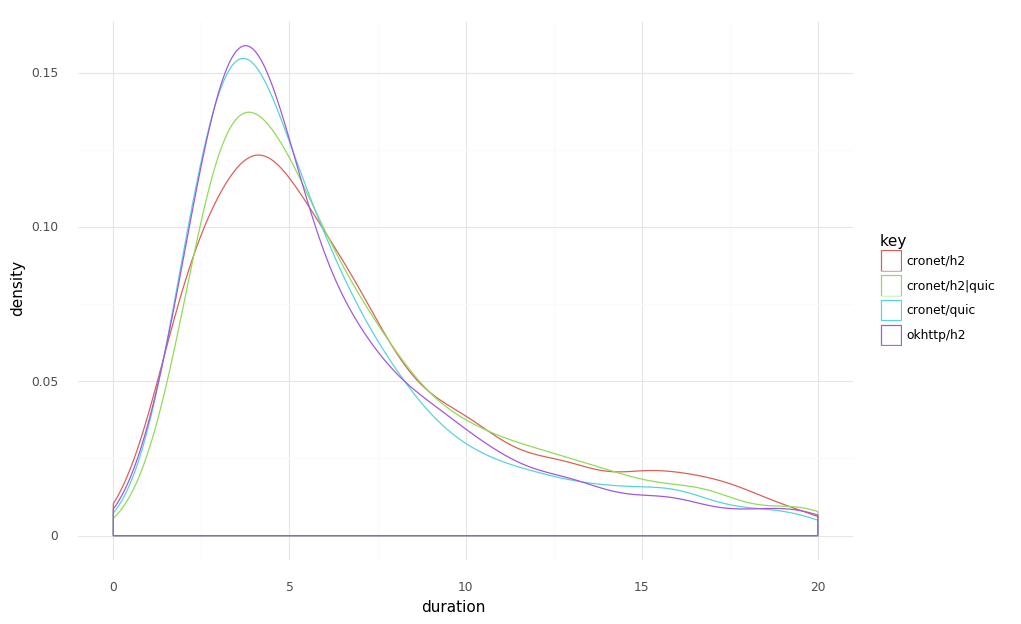

<ggplot: (8754022806817)>

In [467]:
(
    ggplot(df[~df.protocols.str.contains('http/1.1')], aes("duration"))
    + geom_density(aes(colour='key'))
    + xlim(0, 20)
    + theme_minimal()
    + theme(figure_size=(10, 7))
)

In [468]:
%%presto --variable latencyData --email ragrawal@uber.com --cache --use-cache --large-data

SELECT 
    agents
    , protocols
    , APPROX_PERCENTILE(duration, ARRAY [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]) as latencies    
FROM dsp.quic_latencies l
JOIN dsp.quic r ON (r.session_id = l.session_id AND r.user_uuid = l.user_uuid)
WHERE
    city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
    AND os_type = 'android'
    AND NOT is_admin_user 
    AND hosts = 'cfe'
    AND agents in ('cronet', 'okhttp')
GROUP BY agents, protocols

12/05/2018 06:43:43 PM  Created execution 70ee9633-cf1b-4325-9464-964ec5650e05 
2018-12-05 18:43:43,558 queryrunner WARNING  Created execution 70ee9633-cf1b-4325-9464-964ec5650e05 


{'consumer_name': 'data_science', 'user_email': 'ragrawal@uber.com'}


12/05/2018 06:46:04 PM  Query finished. 
2018-12-05 18:46:04,039 queryrunner WARNING  Query finished. 


Saving results to ./qr_cache/3c4fabf4c1f360ca4d0e988d0e9dd378.csv.gz


In [495]:
keys = ['agents', 'protocols']
D = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
df = (
    latencyData
    .set_index(keys)
    .apply(lambda x: pd.Series(dict(zip(D, eval(x.latencies)))), axis=1)
    .reset_index()
    .melt(id_vars=keys, value_vars=D,                                                                       value_name='latency', var_name='latencyBucket')
    .reset_index()
)
df['key'] = df.apply(lambda x: "{}/{}".format(x.agents, x.protocols), axis=1)
df = df[~df.key.str.contains('http/1.1')].copy()

In [496]:
df['Percentiles'] = df.latencyBucket.apply(lambda x: 'P{}'.format(int(x * 100)))

In [497]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

(
    df
    .pivot(index='key', columns='Percentiles', values='latency')
    .style
    .background_gradient(cmap=cm, axis='rows')
)

Percentiles,P10,P20,P30,P40,P50,P60,P70,P80,P90,P95,P99
key,,,,,,,,,,,
cronet/h2,185,266,343,407,469,549,657,820,1347,2688,12288
cronet/h2|quic,224,275,322,373,425,493,589,736,1148,1952,8192
cronet/quic,224,266,302,348,398,456,532,654,933,1472,4864
okhttp/h2,210,259,301,350,403,465,549,686,1012,1664,6400


## Investiage H2|Quic

### Compute how often users transitions from One Protocol to Another

In [318]:
%%presto --variable transitionsDF --email ragrawal@uber.com --cache --use-cache --large-data

SELECT 
    device_id,
    ARRAY_JOIN(ARRAY_AGG(protocol ORDER BY session_start_time_ms), '|') as protocols
FROM 
(
    select 
        device_id,
        session_start_time_ms,
        CASE 
            WHEN protocols = 'h2' THEN 'A'
            WHEN protocols = 'h2|quic' THEN 'B'
            WHEN protocols = 'quic' THEN 'C'
            ELSE 'D'
        END as protocol
    from dsp.quic 
    where 
        city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
        AND os_type = 'android'
        AND NOT is_admin_user 
        AND hosts = 'cfe'
        AND agents = 'cronet'
        AND protocols in ('quic', 'h2', 'h2|quic')
        AND agents in ('cronet', 'okhttp')
) A 
GROUP BY device_id


12/04/2018 10:24:06 PM  Created execution e7de66e4-8182-4cf4-8d96-2d70d2421cd7 
2018-12-04 22:24:06,964 queryrunner WARNING  Created execution e7de66e4-8182-4cf4-8d96-2d70d2421cd7 


{'consumer_name': 'data_science', 'user_email': 'ragrawal@uber.com'}


12/04/2018 10:24:25 PM  Query finished. 
2018-12-04 22:24:25,133 queryrunner WARNING  Query finished. 


Saving results to ./qr_cache/755101c38c805dbed694b8032cb6201b.csv.gz


In [355]:
transitionsDF['states']= transitionsDF.protocols.apply(lambda x: x.split('|'))
transitionsDF['session_cnt'] = transitionsDF.states.apply(lambda x: len(x))
transitionsDF['transitions'] = transitionsDF.states.apply(lambda x: np.sum([ x[idx] != s for idx, s in enumerate(x[1:])]))
transitionsDF.describe()

,session_cnt,transitions
count,312183.000000,312183.000000
mean,1.904947,0.304578
std,2.555668,0.858631
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,114.000000,59.000000


/var/cache/udocker/phoenix-worker/beta/python2/plotnine/stats/smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


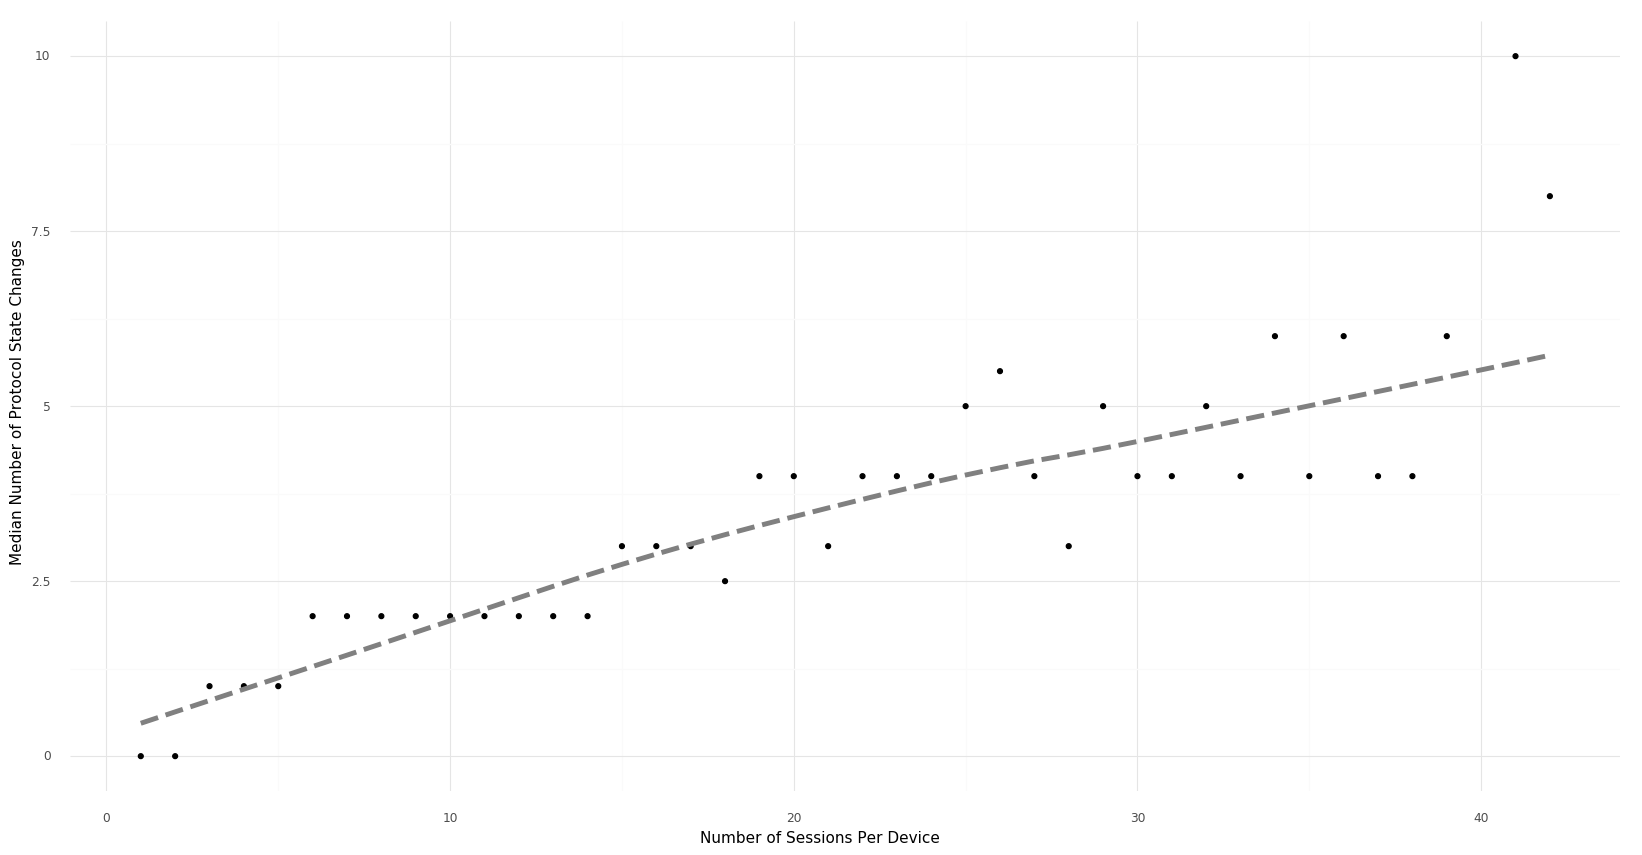

<ggplot: (8754099320029)>

In [371]:
df = transitionsDF.groupby('session_cnt').agg({'transitions': 'median', 'device_id': 'count'}).reset_index()
(
    ggplot(df[df.device_id > 10], aes(x='session_cnt', y='transitions'))
#     + geom_line(aes(group=1), alpha=0.5)
    + geom_point()
    + geom_smooth(aes(group=1), linetype='dashed', size=2, colour='grey')
    + xlab("Number of Sessions Per Device")
    + ylab("Median Number of Protocol State Changes")
    + theme_minimal()
    + theme(figure_size=(20, 10))
)

### Compare Session Lengths 

Longer sessions have more chances of transitions and also increases chances of recording completed. 


In [395]:
%%presto --variable latencyData --email ragrawal@uber.com --cache --use-cache --large-data

SELECT 
    agents, 
    protocols, 
    city,
    client_session_duration_ms as client_ms,
    server_session_duration_ms as server_ms
FROM dsp.quic t
WHERE 
    city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
    AND os_type = 'android'
    AND NOT is_admin_user 
    AND hosts = 'cfe'
    AND agents in ('cronet', 'okhttp')

Loading results from cache file: ./qr_cache/46c5e530fe39fec7d392af0c8b09107c.csv.gz


In [396]:
latencyData['key'] = latencyData.apply(lambda x: "{}/{}".format(x.agents, x.protocols), axis=1)
df = latencyData[latencyData.key.isin(['cronet/h2', 'cronet/h2|quic', 'cronet/quic', 'okhttp/h2'])].copy()

In [400]:
df2 = df.groupby('key').agg({'client_ms': 'mean', 'server_ms': 'mean'}).reset_index()

In [402]:
df3 = df2.melt(id_vars='key', value_vars=['client_ms', 'server_ms'])

In [404]:
df3

,key,variable,value
0,cronet/h2,client_ms,14769.375815
1,cronet/h2|quic,client_ms,34469.094365
2,cronet/quic,client_ms,18648.291417
3,okhttp/h2,client_ms,24087.026557
4,cronet/h2,server_ms,650.532470
5,cronet/h2|quic,server_ms,990.743648
6,cronet/quic,server_ms,850.603328
7,okhttp/h2,server_ms,800.221141


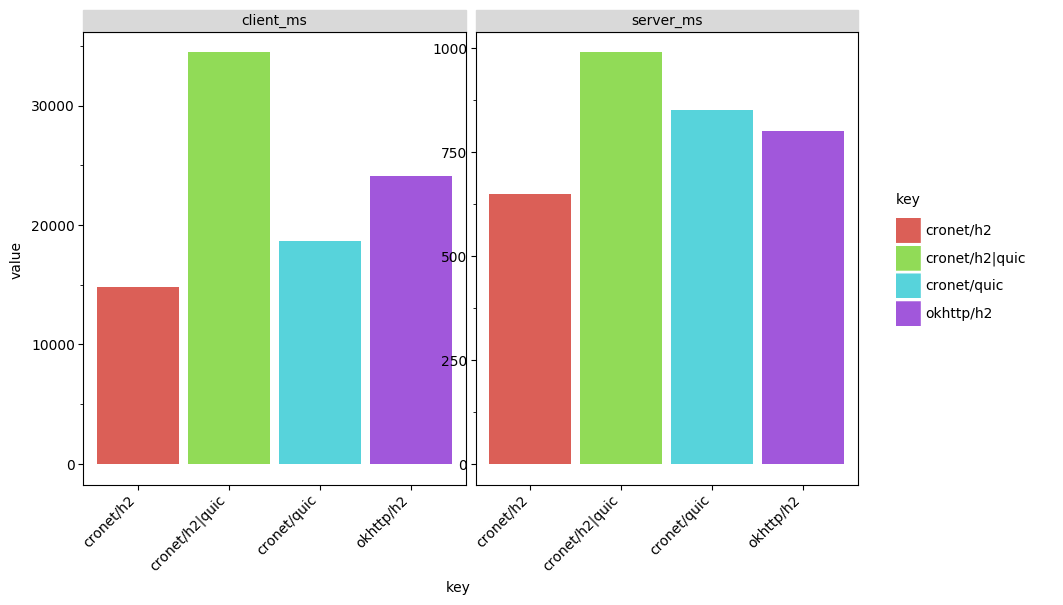

<ggplot: (8753922732973)>

In [418]:
(
    ggplot(df3, aes(x='key', y='value'))
    + geom_bar(aes(fill='key'), stat='identity', position='dodge')
    + facet_wrap("~variable", scales='free')
    + theme_matplotlib()
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(10, 6))

)

### Observe Trend of Sessions For Different Protocols

In [207]:
def intentStats(x):
    return pd.Series({
            'totalSessions': x.shape[0],
            'intentfulSessions': x[x.is_intentful].shape[0]
        })

df = androidExpCities[(androidExpCities.agents == 'cronet') & (androidExpCities.protocols.isin(['h2', 'quic', 'h2|quic']))].groupby(['hosts', 'agents', 'protocols']).apply(intentStats).reset_index()
df['percentIntentful'] = df.apply(lambda x: x.intentfulSessions * 1.0 / x.totalSessions, axis=1)
df.style.format({"percentIntentful": "{:.2%}", "intentfulSessions": "{:,}", "totalSessions": "{:,}"})

,hosts,agents,protocols,intentfulSessions,totalSessions,percentIntentful
0,cfe,cronet,h2,549,"21,774",2.52%
1,cfe,cronet,h2|quic,"11,254","217,740",5.17%
2,cfe,cronet,quic,"10,867","355,178",3.06%


/var/cache/udocker/phoenix-worker/beta/python2/plotnine/stats/smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"
/var/cache/udocker/phoenix-worker/beta/python2/plotnine/stats/smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"
/var/cache/udocker/phoenix-worker/beta/python2/plotnine/stats/smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


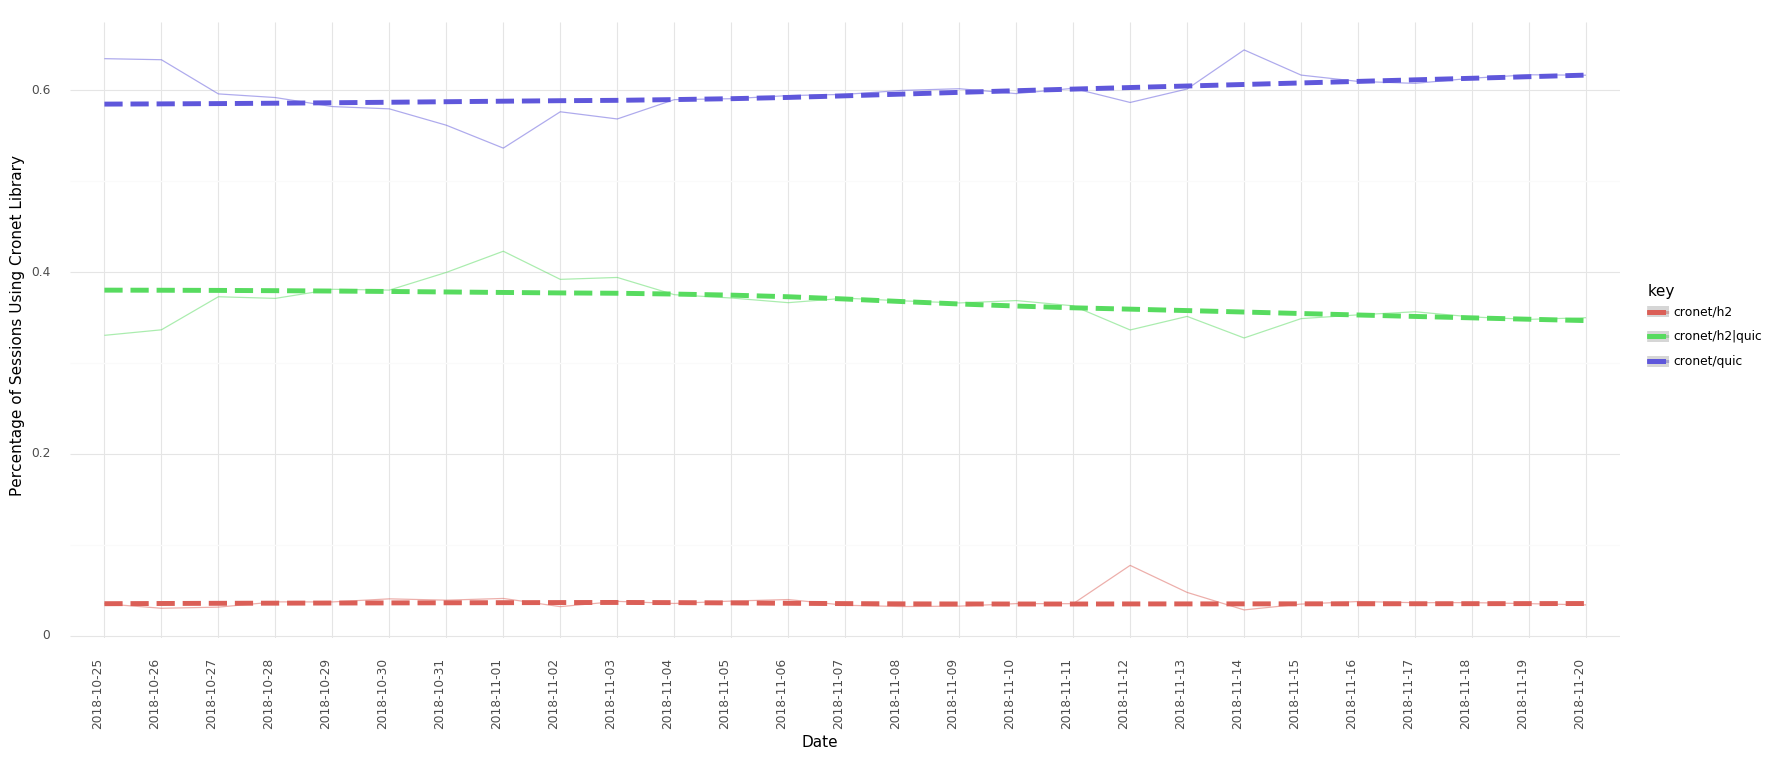

<ggplot: (8754081643193)>

In [208]:
df = androidExpCities[(androidExpCities.agents == 'cronet') & (androidExpCities.protocols.isin(['h2', 'quic', 'h2|quic']))].assign(key=lambda x: "{}/{}".format(x.agents, x.protocols))
df1 = PerGroupCount(df, ['datestr', 'agents', 'protocols'], 'protocolCnt')
df2 = PerGroupCount(df, ['datestr', 'agents'], 'libraryCnt')
df3 = df1.merge(df2, on=['datestr', 'agents']).assign(per=lambda x: x.protocolCnt / x.libraryCnt)
df3['key'] = df3.apply(lambda x: "{}/{}".format(x.agents, x.protocols), axis=1)
(
    ggplot(df3, aes(x='datestr', y='per'))
    + geom_line(aes(colour='key', group='key'), alpha=0.5)
    + geom_smooth(aes(group='key', colour='key'), linetype='dashed', size=2)
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=90, hjust=1), figure_size=(20, 8))
    + xlab("Date") + ylab("Percentage of Sessions Using Cronet Library")
)


/var/cache/udocker/phoenix-worker/beta/python2/plotnine/stats/smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


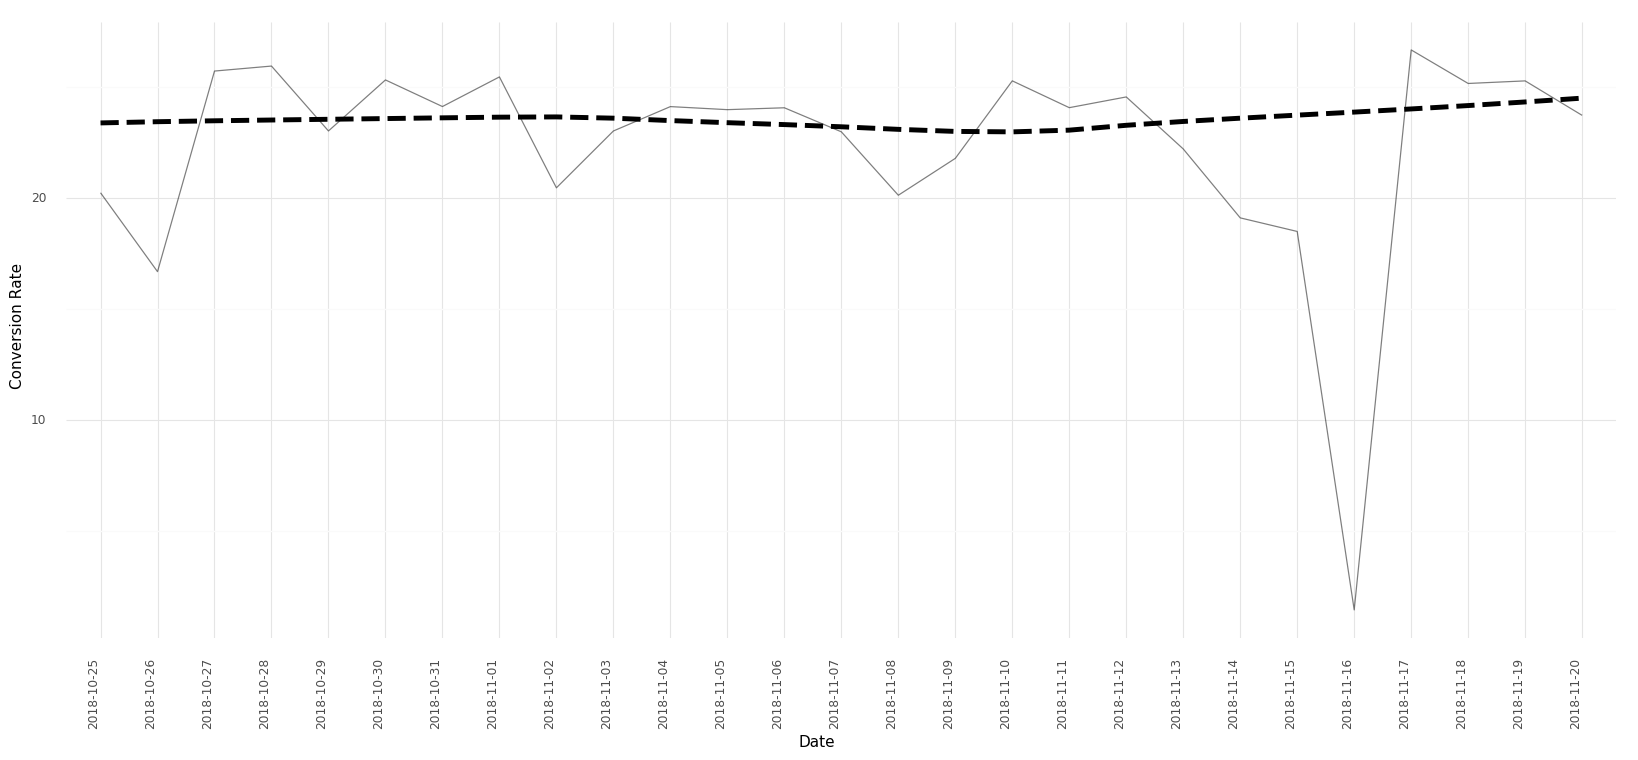

<ggplot: (8754081720217)>

In [220]:
df = androidExpCities[(androidExpCities.agents == 'cronet') & (androidExpCities.protocols.isin(['h2', 'quic', 'h2|quic']))]
df = df.groupby(['datestr']).apply(lambda x: pd.Series({
            'conversion': x[x.n_completed == 1].shape[0] * 100.0 / x.shape[0]
        })).reset_index()
(
    ggplot(df, aes(x='datestr',  y='conversion'))
    + geom_line(aes(group=1), alpha=0.5)
    + geom_smooth(aes(group=1), linetype='dashed', size=2)
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=90, hjust=1), figure_size=(20, 8))
    + xlab("Date") + ylab("Conversion Rate")

)

## User Behavior

In [498]:
import collections
from tqdm import tqdm

df = androidExpCities[(androidExpCities.events.apply(len) > 1)].groupby(['agents', 'protocols']).apply(lambda x: x.sample(min(x.shape[0], 20000))).reset_index(drop=True)
df['key'] = df.apply(lambda x: "{}/{}".format(x.agents, x.protocols), axis=1)
df = df[df.key.isin(['cronet/h2|quic', 'cronet/quic', 'okhttp/h2'])]

transitionsDict = dict((x, collections.defaultdict(float)) for x in np.unique(df['key']))
sourcesDict = dict((x, collections.defaultdict(float)) for x in np.unique(df['key']))
# for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
for idx, row in df.iterrows():
    agent = row['key']
    tokens = row.events
    source = tokens[0]
    for target in tokens[1:]:
        transitionsDict[agent][(source, target)] += 1
        sourcesDict[agent][source] += 1
        source = target

In [499]:
output = []
for agent in np.unique(df['key']):
    print agent
    for t, c in transitionsDict[agent].items():
        output.append([agent, t[0], t[1], c, c/sourcesDict[agent][t[0]]])
        
df = pd.DataFrame(output, columns=['key', 'source', 'target', 'cnt', 'prob'])

cronet/h2|quic
cronet/quic
okhttp/h2


In [500]:
df['sourceName'] = df.source.apply(lambda x: EVENTS[x])
df['targetName'] = df.target.apply(lambda x: EVENTS[x])
df['label'] = df.prob.apply(lambda x: "{:.0%}".format(x))

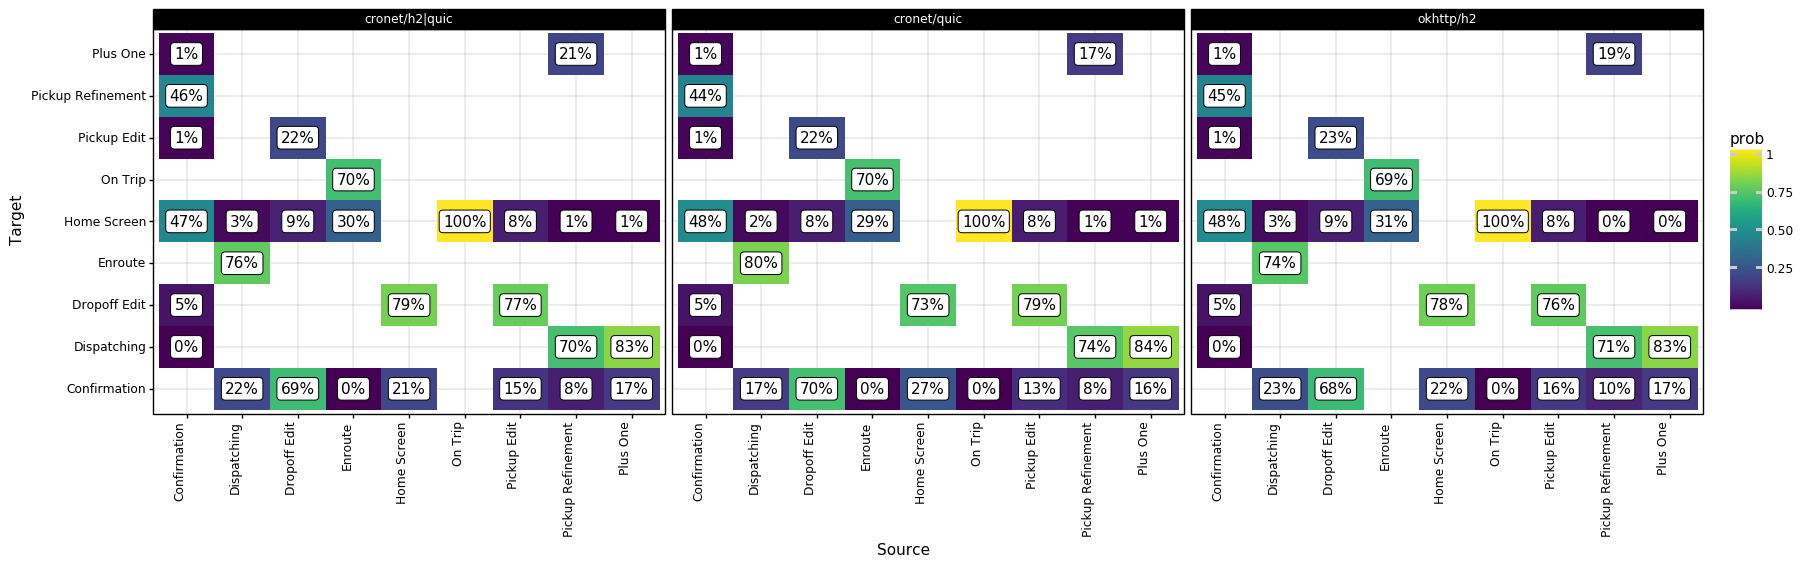

<ggplot: (8754018582241)>

In [505]:
(
    ggplot(df, aes(x='sourceName', y='targetName'))
    + geom_tile(aes(fill='prob'))
    + geom_label(aes(label='label'))
    + facet_wrap("~key")
    + theme_linedraw()
    + theme(figure_size=(20, 5), axis_text_x=element_text(rotation=90, hjust=1))
    + xlab("Source") + ylab("Target")
)

### Investiage Transitions From Home Screen

In [571]:
%%hive --variable userBehaviorDF --email ragrawal@uber.com --cache --use-cache --large-data

WITH stateTime as 
(
    select 
        session_id
        , rider_id 
        , next_state
        , MAX(time_in_state_ms) AS time_in_state_ms
        , SIZE(MAX(accelerators)) AS num_accelerators
        , SUM(IF(a.is_loaded_from_cache, 1, 0)) AS num_cache
    FROM tripex.fact_session_state
    LATERAL VIEW OUTER EXPLODE(accelerators) accelerators AS a
    WHERE 
        datestr BETWEEN '2018-10-25' AND '2018-10-28'
        and name = 'home_screen'
    GROUP BY session_id, rider_id, next_state 
),


sessions AS (
    SELECT * 
    FROM dsp.quic
    where 
        city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
        AND os_type = 'android'
        AND NOT is_admin_user 
        AND hosts = 'cfe'
        AND agents in ('cronet', 'okhttp')
)



SELECT 
    r.agents,
    r.protocols,
    l.*
from sessions r 
join stateTime l 
ON (
    r.session_id = l.session_id 
    AND r.user_uuid = l.rider_id
)



Loading results from cache file: ./qr_cache/a1886825bfd75e38fa95bb49b05c6d43.csv.gz


In [572]:
userBehaviorDF.columns = [x.split('.')[1] for x in userBehaviorDF.columns]

In [573]:
df = userBehaviorDF
df['num_accelerators'] = df.num_accelerators.apply(lambda x: x if x >= 0 else 0)
df['key'] = df.apply(lambda x: "{}/{}".format(x.agents, x.protocols), axis=1)

In [574]:
df = df[df.key.isin(['cronet/quic', 'cronet/h2|quic', 'okhttp/h2'])].copy()
df = df[df.next_state.isin(['confirmation', 'dropoff_edit'])].copy()

In [590]:
df2 = PerGroupCount(df, ['next_state', 'key','num_accelerators'], 'segmentCount').merge(
    PerGroupCount(df, ['next_state', 'key'], 'totalCount'),
    on=['key', 'next_state']
).assign(
    pct = lambda x: x.segmentCount * 1.0 / x.totalCount
)

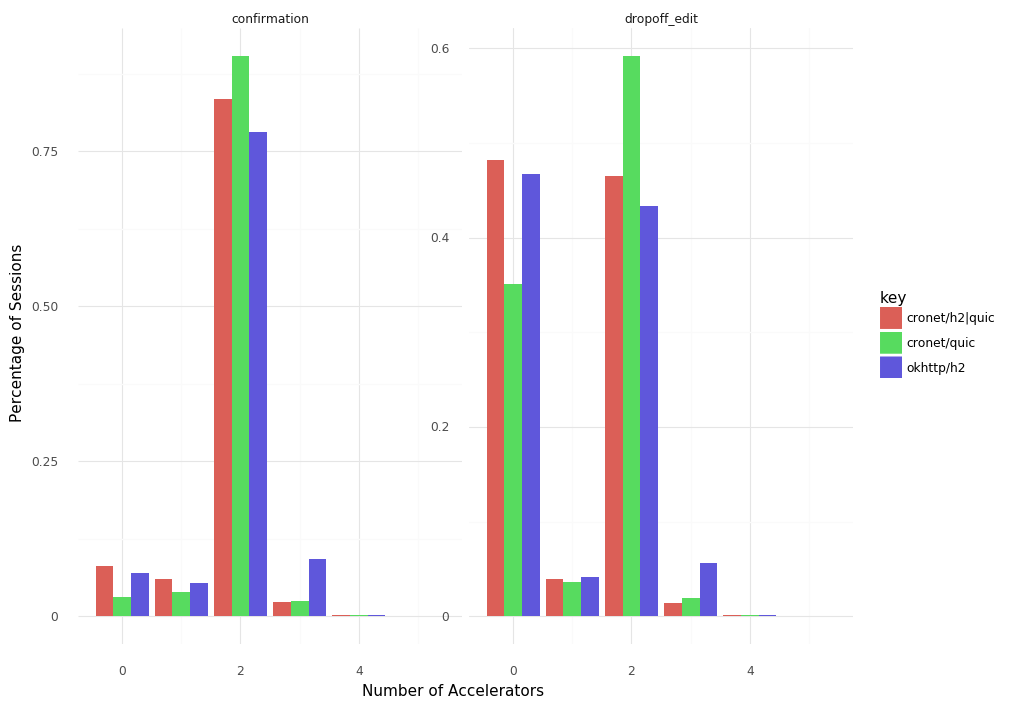

<ggplot: (8754031031965)>

In [598]:
(
    ggplot(df2, aes(x='num_accelerators', y='pct'))
    + geom_bar(aes(fill='key'), stat='identity', position='dodge')
    + facet_wrap("~next_state", scales='free_y')
    + xlab("Number of Accelerators")
    + ylab("Percentage of Sessions")
    + theme_minimal()
    + theme(figure_size=(10, 8))
    
)

In [591]:
df2.pivot_table(
    index=['next_state', 'key'], columns='num_accelerators', values='pct'
).fillna(0).style.format("{:.2%}")
    

In [581]:
(
    ggplot(df[df.next_state == 'confirmation'], aes(x='num_ac'))
    + geom_()
)

PlotnineError: u'stat_boxplot requires the following missing aesthetics: y'

In [533]:
(
    df.groupby(['agents', 'protocols', 'next_state'])[['num_cache']]
    .describe()
    .reset_index()
    .sort_values('next_state')
)

agents protocols    next_state num_cache                                \
                                      count      mean       std  min  25%   
0  cronet   h2|quic  confirmation    6510.0  0.909677  1.716274  0.0  0.0   
2  cronet      quic  confirmation   10230.0  0.938514  1.775622  0.0  0.0   
4  okhttp        h2  confirmation   23442.0  0.914896  2.128755  0.0  0.0   
1  cronet   h2|quic  dropoff_edit   24774.0  0.560063  1.577377  0.0  0.0   
3  cronet      quic  dropoff_edit   30422.0  0.654296  1.577275  0.0  0.0   
5  okhttp        h2  dropoff_edit   86919.0  0.557208  1.770143  0.0  0.0   

                   
   50%  75%   max  
0  0.0  2.0  24.0  
2  0.0  2.0  45.0  
4  0.0  2.0  72.0  
1  0.0  0.0  60.0  
3  0.0  0.0  42.0  
5  0.0  0.0  96.0

In [519]:
(
    df
    .groupby(['agents', 'protocols'])
    .agg({'num_cache': lambda x: np.percentile(x, 90)})
    .reset_index()
    .sort_values(['agents', 'protocols', 'num_cache'])
)

,agents,protocols,num_cache
0,cronet,h2|quic,2
1,cronet,quic,2
2,okhttp,h2,2


In [295]:
90 Percentile to Act On Home Screen (Okhttp/h2): 112 Seconds
90 Percentile to confirm from Home Screen for Cronet / QUIC: 115 seconds

SyntaxError: invalid syntax (<ipython-input-295-d3da3a628870>, line 1)

<string>:1: RuntimeWarning: divide by zero encountered in log
/var/cache/udocker/phoenix-worker/beta/python2/plotnine/layer.py:363: UserWarning: stat_density : Removed 80615 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


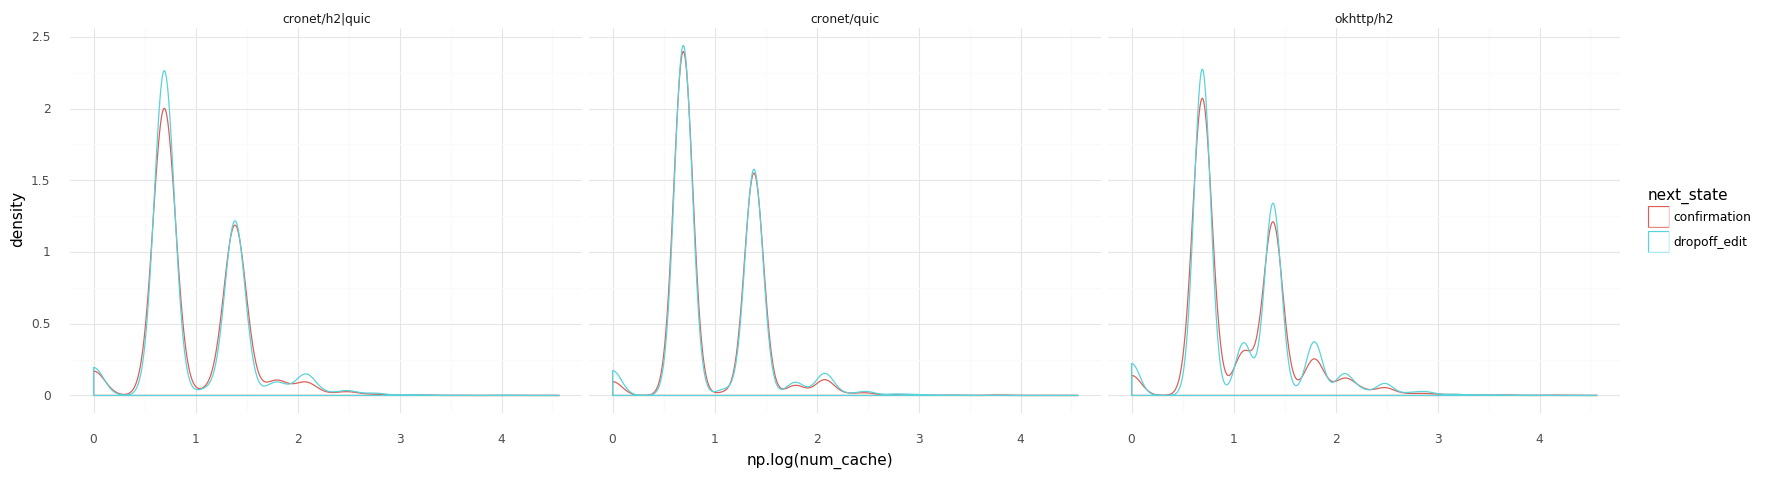

<ggplot: (8754099303713)>

In [315]:
(
    ggplot(df, aes('np.log(num_cache)'))
    + geom_density(aes(colour='next_state'), alpha=0.3)
    + facet_wrap("~key")
    + theme_minimal()
    + theme(figure_size=(20, 5))

)

## Conversion Gain For 5 Cities

In [8]:
def overallAnalysisPreprocessing(data):
    df = (
        data
        .groupby(['n_completed', 'agents'])
        .size()
        .reset_index()
        .rename(columns={0: 'cnt'})
    )
    df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
    df = df.pivot_table(columns='col', values='cnt')
    return df

display(HTML("<h1>Overall Conversion Gain Based On All Sessions</h1>"))
display(stylize(
    overallAnalysis(
        overallAnalysisPreprocessing(androidExpCities)
    )[FIELDS]
))

display(HTML("<h1>Overall Conversion Gain Based On Intentful Sessions</h1>"))
display(stylize(
    overallAnalysis(
        overallAnalysisPreprocessing(androidExpCities[androidExpCities.is_intentful])
    )[FIELDS]
))

col,cronet_session,cronet_conversion,okhttp_session,okhttp_conversion,gain,isSignificant,isPositive
cnt,"594,692",22.32%,"1,014,561",19.55%,2.7654%,True,True


col,cronet_session,cronet_conversion,okhttp_session,okhttp_conversion,gain,isSignificant,isPositive
cnt,"22,670",40.34%,"33,374",38.57%,1.7677%,True,True


## By Protocols

In [37]:
androidExpCities.groupby(['hosts', 'agents', 'protocols']).size().reset_index()

,hosts,agents,protocols,0
0,cfe,cronet,h2,21774
1,cfe,cronet,h2|quic,217740
2,cfe,cronet,quic,355178
3,cfe,okhttp,h2,1014561


### Latency Distribution

In [10]:
%%presto --variable latenciesData --email ragrawal@uber.com --cache --use-cache

SELECT
    agents
    , protocols
    , hosts
    , COUNT(*) as num_sesions
    , APPROX_DISTINCT(CONCAT(s.session_id, '|', s.user_uuid)) as num_distinct_sessions
    , APPROX_PERCENTILE(duration, ARRAY [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]) as latencies
FROM dsp.quic s
JOIN dsp.quic_latencies r
ON (s.session_id = r.session_id AND s.user_uuid = r.user_uuid)
WHERE
    city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
    AND os_type = 'android'
    AND hosts = 'cfe'
    AND NOT is_admin_user
    AND 
    (
        ( agents = 'cronet' AND protocols IN ('quic', 'h2'))
        OR (agents = 'okhttp' AND protocols = 'h2')
    )
GROUP BY agents, hosts, protocols

12/03/2018 06:20:46 PM  Created execution 44b568c8-083d-4ae9-94b6-ce688ad40d7e 
2018-12-03 18:20:46,492 queryrunner WARNING  Created execution 44b568c8-083d-4ae9-94b6-ce688ad40d7e 


{'consumer_name': 'data_science', 'user_email': 'ragrawal@uber.com'}


12/03/2018 06:25:25 PM  Query finished. 
2018-12-03 18:25:25,746 queryrunner WARNING  Query finished. 


Saving results to ./qr_cache/c81828e4d14e6da7e0ae5f04b5b38cc4.csv.gz


In [11]:
latenciesData = processLatencyData(latenciesData)

In [32]:
keys = ['agents', 'hosts', 'protocols']
df = (
    latenciesData
    .set_index(keys)
    .apply(lambda x: pd.Series(dict(zip(DISTRIBUTIONS, x.latencies))), axis=1)
    .reset_index()
    .melt(id_vars=keys, value_vars=DISTRIBUTIONS, value_name='latency', var_name='latencyBucket')
    .reset_index()
)
df['key'] = df.apply(lambda x: "{}/{}/{}".format(x.hosts, x.agents, x.protocols), axis=1)

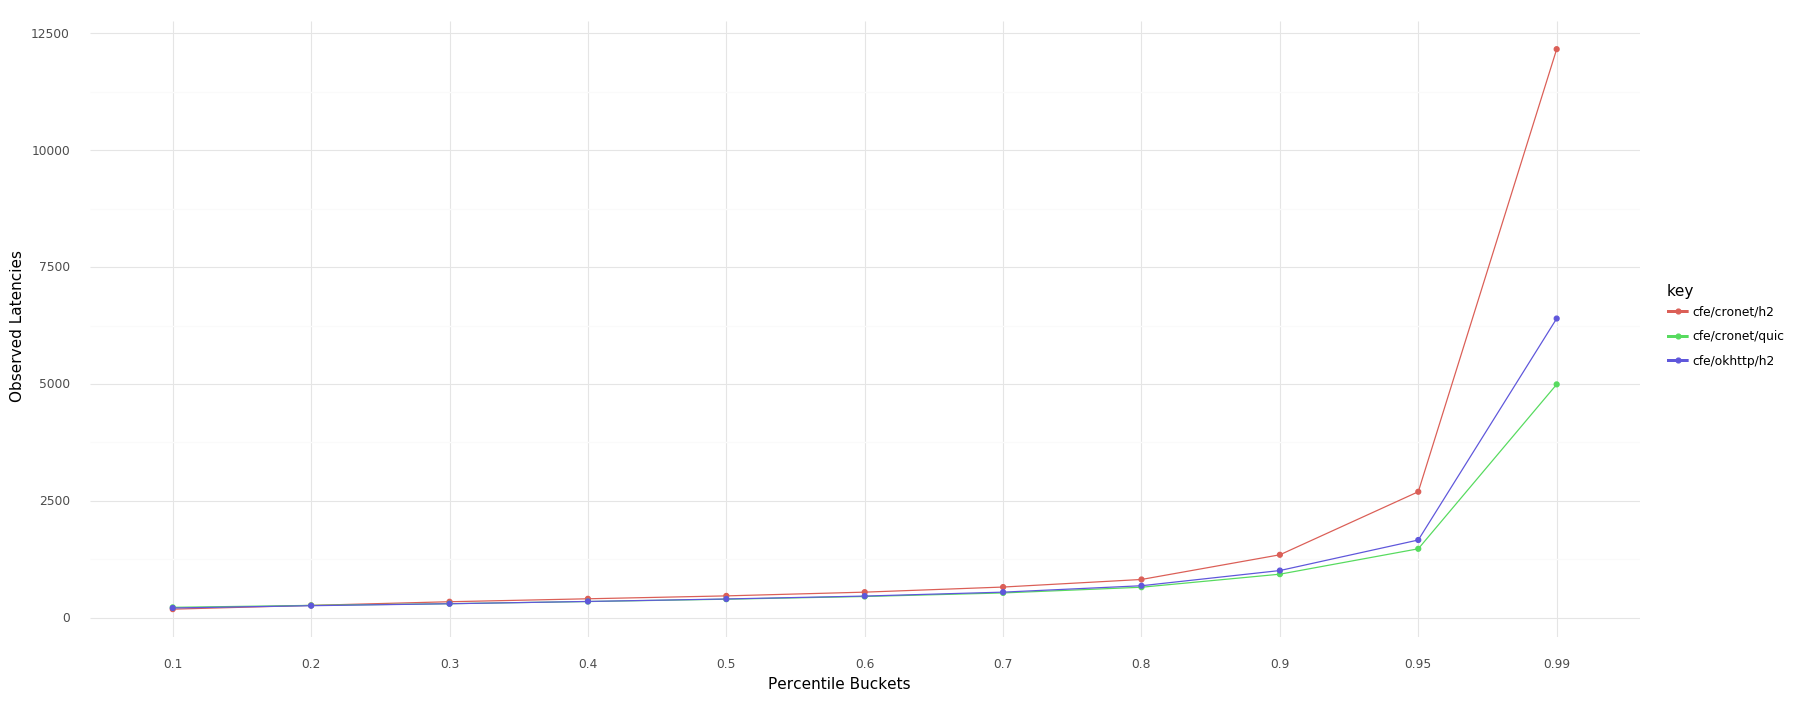

<ggplot: (8753864065549)>

In [33]:

display(
    ggplot(df, aes(x='latencyBucket', y='latency'))
    + geom_line(aes(group='key', colour='key'))
    + geom_point(aes(group='key', colour='key'))
    + theme_minimal()
    + theme(figure_size=(20, 8))
    + xlab("Percentile Buckets") + ylab("Observed Latencies")
)

### User Behavior

In [ ]:
display(androidExpCities.groupby('agents')['eventLen'].describe())
display(stats.ks_2samp(
    androidExpCities[androidExpCities.agents == 'cronet'].eventLen.values,
    androidExpCities[androidExpCities.agents == 'okhttp'].eventLen.values,
))

In [ ]:
(
    ggplot(androidExpCities.sample(10000), aes('np.log(eventLen)'))
    + geom_density(aes(colour='agents'), alpha=0.25)
)

In [ ]:
import collections
from tqdm import tqdm

df = androidExpCities[(androidExpCities.events.apply(len) > 1)].groupby('agents').apply(lambda x: x.sample(20000)).reset_index(drop=True)

transitionsDict = dict((x, collections.defaultdict(float)) for x in AGENTS)
sourcesDict = dict((x, collections.defaultdict(float)) for x in AGENTS)
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
# for idx, row in df.iterrows():
    agent = row.agents
    tokens = row.events
    source = tokens[0]
    for target in tokens[1:]:
        transitionsDict[agent][(source, target)] += 1
        sourcesDict[agent][source] += 1
        source = target

output = []
for agent in AGENTS:
    print agent
    for t, c in transitionsDict[agent].items():
        output.append([agent, t[0], t[1], c, c/sourcesDict[agent][t[0]]])
        
df = pd.DataFrame(output, columns=['agent', 'source', 'target', 'cnt', 'prob'])

In [ ]:
df['sourceName'] = df.source.apply(lambda x: EVENTS[x])
df['targetName'] = df.target.apply(lambda x: EVENTS[x])
df['label'] = df.prob.apply(lambda x: "{:.0%}".format(x))

In [ ]:
(
    ggplot(df, aes(x='sourceName', y='targetName'))
    + geom_tile(aes(fill='prob'))
    + geom_label(aes(label='label'))
    + facet_wrap("~agent")
    + theme_linedraw()
    + theme(figure_size=(20, 10), axis_text_x=element_text(rotation=90, hjust=1))
    + xlab("Source") + ylab("Target")
)

## By City

In [9]:
def overallAnalysisPreprocessing(data):
    df = (
        data
        .groupby(['city', 'n_completed', 'agents'])
        .size()
        .reset_index()
        .rename(columns={0: 'cnt'})
    )
    df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
    df = df.pivot_table(index='city', columns='col', values='cnt')
    return df


display(HTML("<h1>Overall Conversion Gain Based On All Sessions</h1>"))
display(stylize(
    overallAnalysis(
        overallAnalysisPreprocessing(androidExpCities)
    )[FIELDS]
))

display(HTML("<h1>Overall Conversion Gain Based On Intentful Sessions</h1>"))
display(stylize(
    overallAnalysis(
        overallAnalysisPreprocessing(androidExpCities[androidExpCities.is_intentful])
    )[FIELDS]
))

col,cronet_session,cronet_conversion,okhttp_session,okhttp_conversion,gain,isSignificant,isPositive
city,,,,,,,
cairo,"63,729",23.05%,"105,887",20.71%,2.3431%,True,True
london,"58,624",32.91%,"107,535",30.41%,2.4985%,True,True
los_angeles,"25,038",28.82%,"48,744",26.31%,2.5133%,True,True
new_delhi,"124,637",21.72%,"212,348",18.56%,3.1558%,True,True
sao_paulo,"322,664",19.98%,"540,047",16.95%,3.0322%,True,True


col,cronet_session,cronet_conversion,okhttp_session,okhttp_conversion,gain,isSignificant,isPositive
city,,,,,,,
cairo,"2,610",44.44%,"3,627",42.38%,2.0678%,False,True
london,"1,628",60.87%,"2,593",58.70%,2.1757%,False,True
los_angeles,744,52.42%,"1,215",56.05%,-3.6300%,False,False
new_delhi,"4,532",33.23%,"7,451",30.79%,2.4425%,True,True
sao_paulo,"13,156",38.75%,"18,488",36.99%,1.7588%,True,True


### Latency Distribution

In [ ]:
%%presto --variable latenciesData --email ragrawal@uber.com --cache --use-cache

SELECT
    city
    , agents
    , protocols
    , hosts
    , COUNT(*) as num_sesions
    , APPROX_DISTINCT(CONCAT(s.session_id, '|', s.user_uuid)) as num_distinct_sessions
    , APPROX_PERCENTILE(duration, ARRAY [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]) as latencies
FROM dsp.quic s
JOIN dsp.quic_latencies r
ON (s.session_id = r.session_id AND s.user_uuid = r.user_uuid)
WHERE
        city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
        AND os_type = 'android'
        AND hosts = 'cfe'
        AND 
        (
            ( agents = 'cronet' AND protocols = 'quic')
            OR (agents = 'okhttp' AND protocols = 'h2')
        )
GROUP BY city, agents, hosts, protocols

In [ ]:
keys = ['city', 'agents', 'protocols', 'hosts']
df = (
    latenciesData
    .set_index(keys)
    .apply(lambda x: pd.Series(dict(zip(DISTRIBUTIONS, latency_parser(x.latencies)))), axis=1)
    .reset_index()
    .melt(id_vars=keys, value_vars=DISTRIBUTIONS, value_name='latency', var_name='latencyBucket')
    .reset_index()
)

In [ ]:
dfRow = df.pivot_table(index=['city', 'latencyBucket'], columns='agents', values='latency').reset_index()
dfRow['PctDrop'] = (dfRow.okhttp - dfRow.cronet) * 100.0 / dfRow.okhttp

In [ ]:
(
    ggplot(dfRow, aes(x='latencyBucket', y='PctDrop'))
    + geom_line(aes(colour='city'))
    + geom_point(aes(colour='city'))
    + theme_minimal()
    + theme(figure_size=(20, 8))
    
)

### User Behavior

In [ ]:
display(androidExpCities.groupby(['city', 'agents'])['eventLen'].describe())

In [ ]:
(
    ggplot(androidExpCities.sample(50000), aes('np.log(eventLen)'))
    + geom_density(aes(colour='agents'), alpha=0.25)
    + facet_wrap("~city")
    + theme_minimal()
    + theme(figure_size=(20, 10))
)

In [ ]:
import collections
from tqdm import tqdm

df = androidExpCities[(androidExpCities.events.apply(len) > 1)].groupby(['city', 'agents']).apply(lambda x: x.sample(10000)).reset_index(drop=True)

transitionsDict = dict(((c, x), collections.defaultdict(float)) for x in AGENTS for c in EXPERIMENT_CITIES)
sourcesDict = dict(((c,x), collections.defaultdict(float)) for x in AGENTS for c in EXPERIMENT_CITIES)

# for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
for idx, row in df.iterrows():
    
    a = row.agents
    c = row.city
    
    tokens = row.events
    source = tokens[0]

    for target in tokens[1:]:
        transitionsDict[(c, a)][(source, target)] += 1
        sourcesDict[(c, a)][source] += 1
        source = target

output = []
for a in AGENTS:
    for c in EXPERIMENT_CITIES:
        for t, cnt in transitionsDict[(c, a)].items():
            output.append([c, a, t[0], t[1], cnt, cnt/sourcesDict[(c, a)][t[0]]])
        
df = pd.DataFrame(output, columns=['city', 'agent', 'source', 'target', 'cnt', 'prob'])

In [ ]:
df['sourceName'] = df.source.apply(lambda x: EVENTS[x])
df['targetName'] = df.target.apply(lambda x: EVENTS[x])
df['label'] = df.prob.apply(lambda x: "{:.0%}".format(x))

In [ ]:
(
    ggplot(df, aes(x='sourceName', y='targetName'))
    + geom_tile(aes(fill='prob'))
    + geom_label(aes(label='label'))
    + facet_grid("city ~ agent")
    + theme_linedraw()
    + theme(figure_size=(15, 42), axis_text_x=element_text(rotation=90, hjust=1))
    + xlab("Source") + ylab("Target")
)

## By Date

In [ ]:
df = (
    androidExpCities
    .groupby(['city', 'datestr', 'n_completed', 'agents'])
    .size()
    .reset_index()
    .rename(columns={0: 'cnt'})
)
df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
df = df.pivot_table(index=['city', 'datestr'], columns='col', values='cnt')
stylize(overallAnalysis(df)[FIELDS])

### Latency Distribution

In [ ]:
df = (
    androidExpCities[~androidExpCities.latency_distribution.isnull()]
    .groupby(['agents', 'datestr', 'n_completed'])
    .apply(lambda x: pd.Series(dict(zip(DISTRIBUTIONS, extract_distribution(x.latency_distribution, np.median)))))
    .reset_index()
    .melt(id_vars=['agents', 'datestr', 'n_completed'], value_vars=DISTRIBUTIONS, value_name='latency_distribution', var_name='latencyBucket')
    .reset_index()
)

In [ ]:
dfRow = df.pivot_table(index=['latencyBucket', 'datestr', 'n_completed'], columns='agents', values='latency_distribution').reset_index()
dfRow['PctDrop'] = (dfRow.okhttp - dfRow.cronet) * 100.0 / dfRow.okhttp
dfRow['n_completed'] = dfRow.n_completed.astype(str)
dfRow = dfRow[dfRow.latencyBucket.isin([0.1, 0.5, 0.9, 0.95, 0.99])].copy()
dfRow['latencyBucket'] = dfRow.latencyBucket.astype(str)


In [ ]:
(
    ggplot(dfRow, aes(x='datestr', y='PctDrop'))
    + geom_line(aes(colour='latencyBucket', group='latencyBucket'))
    + geom_point(aes(colour='latencyBucket'))
    + facet_wrap("~n_completed")
    + theme(figure_size=(20, 8))
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
)

## By City & Device Year Class

In [ ]:
df = (
    androidExpCities
    .groupby(['city', 'device_year_class', 'n_completed', 'agents'])
    .size()
    .reset_index()
    .rename(columns={0: 'cnt'})
)
df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
df = df.pivot_table(index=['city', 'device_year_class'], columns='col', values='cnt')
df = overallAnalysis(df).reset_index()
df['label'] = df.gain.apply(lambda x: "{:.2}".format(x))
df.head(4)

In [ ]:
(
    ggplot(df, aes(x='city', y='device_year_class'))
    + geom_tile(aes(fill='isPositive'), colour='black')
    + geom_label(aes(label='label'))
    + theme_minimal()
    + theme(figure_size=(8, 5))
)

# IOS 5 Archetype Cities

In [ ]:
%%presto --variable iosData --email ragrawal@uber.com --cache --use-cache --encoding utf8 --large-data

SELECT * 
FROM dsp.quic
WHERE 
    city in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
    and os_type = 'ios'
    and agents in ('cronet', 'okhttp')

In [ ]:
iosExpCities = processData(iosData)

## Overall

In [ ]:
df = (
    iosExpCities
    .groupby(['n_completed', 'agents'])
    .size()
    .reset_index()
    .rename(columns={0: 'cnt'})
)
df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
df = df.pivot_table(columns='col', values='cnt')
stylize(overallAnalysis(df)[FIELDS])

### Latency Distribution

In [ ]:
df = (
    iosExpCities[~iosExpCities.latency_distribution.isnull()]
    .groupby(['agents', 'n_completed'])
    .apply(lambda x: pd.Series(dict(zip(DISTRIBUTIONS, extract_distribution(x.latency_distribution, np.median)))))
    .reset_index()
    .melt(id_vars=['agents', 'n_completed'], value_vars=DISTRIBUTIONS, value_name='latency_distribution', var_name='latencyBucket')
    .reset_index()
)

In [ ]:
dfRow = df.pivot_table(index=['latencyBucket', 'n_completed'], columns='agents', values='latency_distribution').reset_index()
dfRow['PctDrop'] = (dfRow.okhttp - dfRow.cronet) * 100.0 / dfRow.okhttp
dfRow['n_completed'] = dfRow.n_completed.astype(str)
(
    ggplot(dfRow, aes(x='latencyBucket', y='PctDrop'))
    + geom_line(aes(colour='n_completed'))
    + geom_point(aes(colour='n_completed'))
    + theme(figure_size=(20, 8))
    
)

### User Behavior

## By City

In [ ]:
df = (
    iosExpCities
    .groupby(['city', 'n_completed', 'agents'])
    .size()
    .reset_index()
    .rename(columns={0: 'cnt'})
)
df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
df = df.pivot_table(index='city', columns='col', values='cnt')
stylize(overallAnalysis(df)[FIELDS])

In [ ]:
df = (
    iosExpCities[~iosExpCities.latency_distribution.isnull()]
    .groupby(['agents', 'city'])
    .apply(lambda x: pd.Series(dict(zip(DISTRIBUTIONS, extract_distribution(x.latency_distribution, np.median)))))
    .reset_index()
    .melt(id_vars=['agents', 'city'], value_vars=DISTRIBUTIONS, value_name='latency_distribution', var_name='latencyBucket')
)

In [ ]:
dfRow = df.pivot_table(index=['city', 'latencyBucket'], columns='agents', values='latency_distribution').reset_index()
dfRow['PctDrop'] = (dfRow.okhttp - dfRow.cronet) / dfRow.okhttp
(
    ggplot(dfRow, aes(x='latencyBucket', y='PctDrop'))
    + geom_line(aes(colour='city'))
    + xlab("Latency Percentile Bucket") 
    + ylab("Pct Drop In Latency (cronet - okhttp / okhttp)")
)

## By Date

In [ ]:
df = (
    iosExpCities
    .groupby(['datestr', 'n_completed', 'agents'])
    .size()
    .reset_index()
    .rename(columns={0: 'cnt'})
)
df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
df = df.pivot_table(index='datestr', columns='col', values='cnt')
stylize(overallAnalysis(df)[FIELDS])

In [ ]:
df = (
    iosExpCities[~iosExpCities.latency_distribution.isnull()]
    .groupby(['agents', 'datestr', 'n_completed'])
    .apply(lambda x: pd.Series(dict(zip(DISTRIBUTIONS, extract_distribution(x.latency_distribution, np.median)))))
    .reset_index()
    .melt(id_vars=['agents', 'datestr', 'n_completed'], value_vars=DISTRIBUTIONS, value_name='latency_distribution', var_name='latencyBucket')
)

In [ ]:
dfRow = df.pivot_table(index=['datestr', 'latencyBucket', 'n_completed'], columns='agents', values='latency_distribution').reset_index()
dfRow['PctDrop'] = (dfRow.okhttp - dfRow.cronet) / dfRow.okhttp

In [ ]:
dfPlot = dfRow[dfRow.latencyBucket.isin([0.1, 0.5, 0.90, 0.95, 0.99])].copy().reset_index()
dfPlot['latencyBucket'] = dfPlot.latencyBucket.astype(str)

(
    ggplot(dfPlot, aes(x='datestr', y='PctDrop'))
    + geom_line(aes(colour='latencyBucket', group='latencyBucket'))
    + theme(axis_text_x=element_text(rotation=90, hjust=1), figure_size=(20, 10))
    + facet_wrap('~n_completed')
    
)

# Android Rest of World

In [ ]:
%%presto --variable androidROW --email ragrawal@uber.com --cache --use-cache --encoding utf8 --large-data

SELECT *
FROM dsp.quic
WHERE 
    city not in ('sao_paulo', 'london', 'los_angeles', 'cairo', 'new_delhi')
    and os_type = 'android'
    AND hosts = 'cfe'
    (
        ( agents = 'cronet' AND protocols = 'quic')
        OR (agents = 'okhttp' AND protocols = 'h2')
    )


In [ ]:
androidROW = pd.read_csv("qr_cache/androidRow.csv", na_values='\N')
androidROW.shape

In [ ]:
androidCities = processData(androidROW)

## Identify City Level Conversion Trend

In [ ]:
df = (
    androidCities
    .groupby(['city', 'n_completed', 'agents'])
    .size()
    .reset_index()
    .rename(columns={0: 'cnt'})
)
df['col'] = df.apply(lambda x: x.agents + ['_missed', '_hit'][x.n_completed], axis=1)
df = df.pivot_table(index='city', columns='col', values='cnt').reset_index()
df = df.assign(
    cronet_sessions = lambda x: x.cronet_hit + x.cronet_missed,
    okhttp_sessions = lambda x: x.okhttp_hit + x.okhttp_missed,
    cronet_conversion = lambda x: x.cronet_hit / (x.cronet_hit + x.cronet_missed),
    okhttp_conversion = lambda x: x.okhttp_hit / (x.okhttp_hit + x.okhttp_missed),
)

In [ ]:
print "Total Number of Cities: ", df.shape[0]
df = df[(~df.cronet_sessions.isnull())]
df = df[(~df.okhttp_sessions.isnull())]
df = df[(df.cronet_conversion > 0) & (df.cronet_conversion < 1.0)]
df = df[(df.okhttp_conversion > 0) & (df.okhttp_conversion < 1.0)]
print "After Filtering: ", df.shape[0]


In [ ]:
df2 = overallAnalysis(df)

In [ ]:
stylize(df2[(df2.isSignificant) & (df2.power > 0.7)])

### Latency Distribution

In [ ]:
df = (
    androidCities[~androidCities.latency_distribution.isnull()]
    .groupby(['city', 'agents', 'n_completed'])
    .apply(lambda x: pd.Series(dict(zip(DISTRIBUTIONS, extract_distribution(x.latency_distribution, np.median)))))
    .reset_index()
    .melt(id_vars=['city', 'agents', 'n_completed'], value_vars=DISTRIBUTIONS, value_name='latency_distribution', var_name='latencyBucket')
    .reset_index()
)

In [ ]:
dfRow = df.pivot_table(index=['city', 'latencyBucket', 'n_completed'], columns='agents', values='latency_distribution').reset_index()
dfRow = dfRow[dfRow.city.isin(['honolulu', 'porto_velho'])]
dfRow['PctDrop'] = (dfRow.okhttp - dfRow.cronet) * 100.0 / dfRow.okhttp
dfRow['n_completed'] = dfRow.n_completed.astype(str)
(
    ggplot(dfRow, aes(x='latencyBucket', y='PctDrop'))
    + geom_line(aes(colour='city'))
    + geom_point(aes(colour='city'))
    + theme(figure_size=(20, 8))
    + facet_wrap("~n_completed", scales='free')
    
)

In [ ]:
PROTOCOLS = """

h2
h2
h2
h2|quic
h2|quic
h2|quic
h2
h2
h2|http/1.1
quic

h2
h2
h2
quic
h2
quic
h2
h2|http/1.1
http/1.1
h2|quic
http/1.1
h2|quic
h2
quic
h2|http/1.1
h2
h2
quic
quic
h2|quic
h2|quic
h2
h2
h2
h2|quic
h2|http/1.1
h2
quic
h2|quic
h2
h2
h2|quic
http/1.1
quic
h2|quic
quic
http/1.1
h2
quic
quic
quic
h2
quic
h2

h2
quic
h2|http/1.1

quic
h2
quic
h2|http/1.1|quic
h2|quic
h2|http/1.1|quic
h2
h2
h2|http/1.1|quic
h2
h2|quic

h2
h2
h2|quic
h2|quic

h2
quic
h2|quic
http/1.1

h2
h2
h2
http/1.1
h2|http/1.1
quic
h2|http/1.1
h2
h2|http/1.1
quic
quic
h2
h2
http/1.1|quic
h2
h2|http/1.1
quic
h2|quic
h2|http/1.1|quic
http/1.1
h2|quic
h2|quic
http/1.1
http/1.1|quic
h2
http/1.1
quic
h2|quic
h2
h2
h2|quic
h2|quic
h2|http/1.1|quic
h2|quic
http/1.1
quic
http/1.1|quic
h2
h2
quic
h2
h2

h2|quic
h2|http/1.1
http/1.1
h2|quic
h2
h2|quic
quic
h2
quic
quic
h2|quic
h2
h2
http/1.1|quic
h2

h2|quic
quic
quic
h2
h2
http/1.1
quic
h2|quic
h2
h2
h2
quic
h2|quic
h2

h2|quic
h2
h2|http/1.1|quic
quic
h2
h2
h2|http/1.1|quic
h2
h2|quic
quic
h2
http/1.1|quic
quic
h2
quic
h2
h2|quic
h2
h2
h2
h2|http/1.1|quic
http/1.1
quic
h2|quic
h2
quic
h2
h2
h2
h2
h2|quic
quic
h2|quic
h2|quic
h2
h2
quic
quic

quic
http/1.1
h2|quic
h2
quic
http/1.1
http/1.1
quic
http/1.1
quic
quic
h2
quic
http/1.1

quic
http/1.1
h2|quic
h2
http/1.1
h2
h2|quic
h2
http/1.1
http/1.1
h2
h2|quic
http/1.1
h2|quic
h2
http/1.1
h2|http/1.1
h2
h2
h2|quic
h2
h2|quic
h2
h2
h2|http/1.1
h2|quic
h2|quic
h2
h2|quic
http/1.1
h2|http/1.1
quic
h2
quic
h2
http/1.1
http/1.1
h2|http/1.1
http/1.1
quic
h2|quic
h2
h2|quic
quic
quic
h2|http/1.1
h2|quic
quic
quic
h2|http/1.1
h2
h2
h2|quic
h2|http/1.1|quic
h2
h2

h2|http/1.1

h2
h2
h2|quic
h2
h2|quic
quic
quic
h2|quic
h2|quic
h2
h2|http/1.1|quic
h2|quic
h2|quic
h2
h2
quic
h2
h2

http/1.1
quic
h2
"""

In [ ]:
ps = set()
for p in PROTOCOLS.split("\n"):
    if len(p.strip()) == 0:
        continue
    tokens = p.split('|')
    for t in tokens:
        ps.add(t)
        
print ps